In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import mstats
import os
import importlib

In [18]:
# --- Step 1: Load Data ---
file_path = os.getcwd() + '/data/Factor_data.xlsx'
df = pd.read_excel(file_path, sheet_name='ws_fund', index_col=0)
df = df.tail(24).copy()

"""
# Winsorize and standardize factors
for col in ['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']:
    df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])
    df[col] = (df[col] - df[col].mean()) / df[col].std()
"""

"\n# Winsorize and standardize factors\nfor col in ['Quality', 'Momentum', 'Value', 'Low_vol', 'Market']:\n    df[col] = mstats.winsorize(df[col], limits=[0.05, 0.05])\n    df[col] = (df[col] - df[col].mean()) / df[col].std()\n"

In [19]:
market_neutral_factors = {}

for factor in ['Quality', 'Momentum', 'Value', 'Low_vol']:
    # Prepare regression variables
    x_market = sm.add_constant(df['Market'])
    y_factor = df[factor]

    
    # Run regression
    model = sm.OLS(y_factor, x_market).fit()
    
    # Get residuals (market-neutral factor returns)
    market_neutral_factors[factor] = model.resid

# Add market-neutral factors to DataFrame
for factor in market_neutral_factors:
    df[f'{factor}_mn'] = market_neutral_factors[factor]

# Now use ['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn'] as your factors in further analysis

print(df.columns)

Index(['Net Return', 'Benchmark Return', 'Quality', 'Momentum', 'Value',
       'Low_vol', 'Market', 'Quality_mn', 'Momentum_mn', 'Value_mn',
       'Low_vol_mn'],
      dtype='object')


In [ ]:
# --- Step 3: Prepare Regression Variables ---
# X = df[['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn']] #, 'Market']]
X = df[['Quality', 'Momentum', 'Value', 'Low_vol']] 
y = df['Net Return'] # - df['Benchmark Return']

# Add constant for intercept
X = sm.add_constant(X)

# --- Step 4: Run Regression ---
model = sm.OLS(y, X).fit()
print(model.summary())

# --- Step 5: Get Betas (Factor Sensitivities) ---
betas = model.params.drop('const')
print(betas)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.7188
Date:                Tue, 16 Sep 2025   Prob (F-statistic):              0.590
Time:                        14:41:49   Log-Likelihood:                 90.055
No. Observations:                  24   AIC:                            -170.1
Df Residuals:                      19   BIC:                            -164.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      2.242      0.0

In [21]:
# --- Step 6: Calculate Factor Variances and Covariances ---
#factor_returns = df[['Quality_mn', 'Momentum_mn', 'Value_mn', 'Low_vol_mn']] #, 'Market']]
factor_returns = df[['Quality', 'Momentum', 'Value', 'Low_vol']] 
factor_cov = factor_returns.cov()
factor_var = factor_returns.var()

factor_cov

,Quality,Momentum,Value,Low_vol
Quality,0.002823,0.003037,0.002789,0.001803
Momentum,0.003037,0.003986,0.003434,0.002056
Value,0.002789,0.003434,0.003602,0.001938
Low_vol,0.001803,0.002056,0.001938,0.001482


In [22]:
# --- Step 7: Calculate Risk Attribution ---
# Portfolio variance explained by factors
risk_contributions = {}
for i, factor in enumerate(factor_returns.columns):
    # Variance term
    var_term = betas[factor]**2 * factor_var[factor]
    # Covariance terms
    cov_term = 0
    for j, other_factor in enumerate(factor_returns.columns):
        if i != j:
            cov_term += betas[factor] * betas[other_factor] * factor_cov.loc[factor, other_factor]
    # Total contribution
    risk_contributions[factor] = var_term + cov_term

# Residual (unexplained) risk
residual_var = model.resid.var()

# --- Step 8: Summarize Results ---
total_risk = sum(risk_contributions.values()) + residual_var

print("\nRisk Attribution (Absolute):")
for factor, contribution in risk_contributions.items():
    print(f"{factor}: {contribution:.6f} ({contribution/total_risk:.2%} of total risk)")
print(f"Residual: {residual_var:.6f} ({residual_var/total_risk:.2%} of total risk)")
print(f"Total Portfolio Variance: {total_risk:.6f}")


Risk Attribution (Absolute):
Quality: 0.000000 (0.01% of total risk)
Momentum: 0.000001 (2.80% of total risk)
Value: 0.000001 (2.60% of total risk)
Low_vol: 0.000003 (7.74% of total risk)
Residual: 0.000034 (86.86% of total risk)
Total Portfolio Variance: 0.000039


Portfolio Risk Attribution Analysis
Total Portfolio Variance: 0.000039

Risk Attribution Table:
  Factor  Absolute_Risk  Risk_Percentage
 Quality   2.744082e-09         0.007086
Momentum   1.083233e-06         2.797179
   Value   1.004983e-06         2.595118
 Low_vol   2.999317e-06         7.744987
Residual   3.363564e-05        86.855630


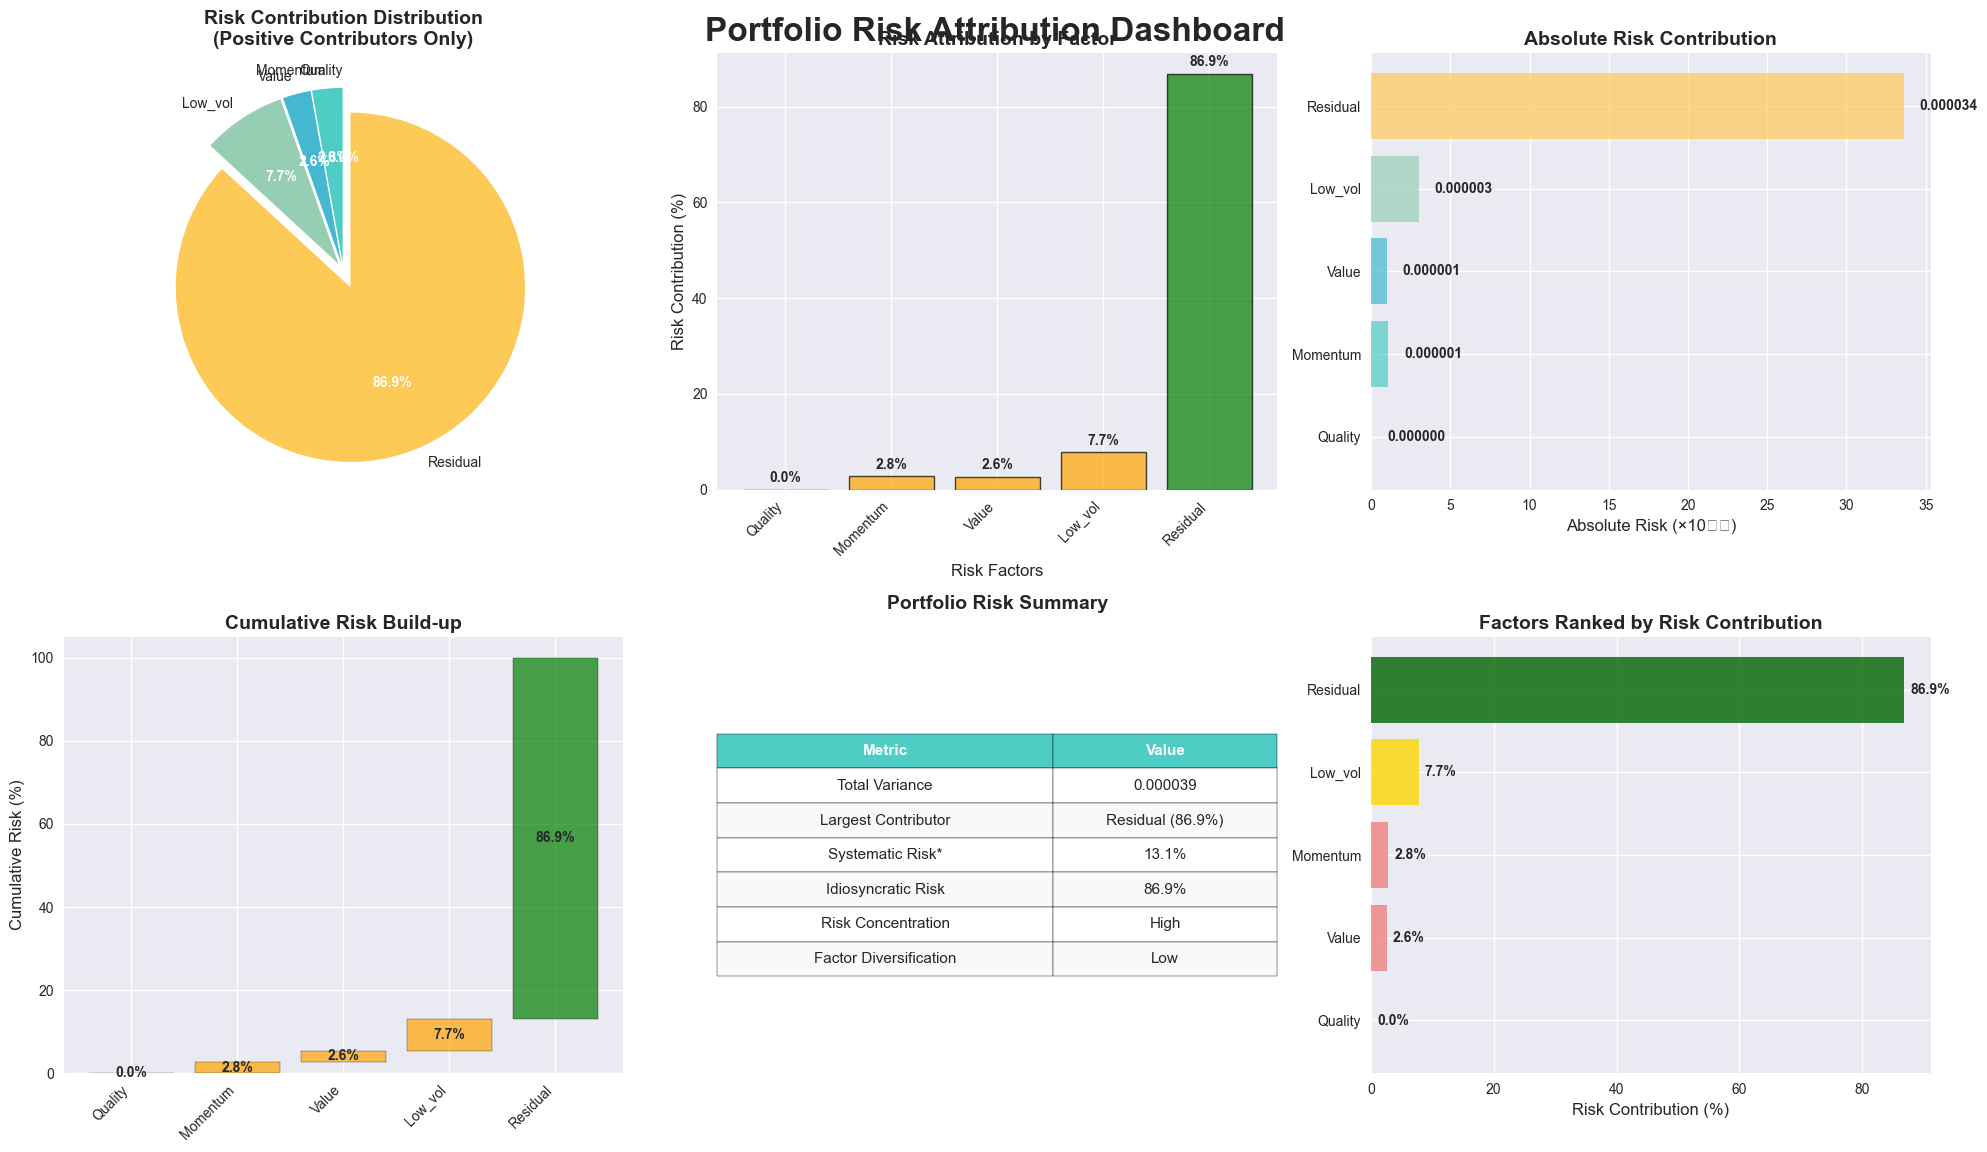


RISK ANALYSIS INSIGHTS

🔍 KEY FINDINGS:
• Residual risk dominates the portfolio (86.9%)
• Systematic risk factors contribute 13.1% of total risk
• Residual is the largest systematic contributor (86.9%)
• Portfolio shows HIGH concentration risk

📊 RISK DECOMPOSITION:
• Quality     :   0.01% 🟢 LOW
• Momentum    :   2.80% 🟢 LOW
• Value       :   2.60% 🟢 LOW
• Low_vol     :   7.74% 🟢 LOW
• Residual    :  86.86% 🔴 HIGH

💡 RECOMMENDATIONS:
• Consider increasing factor exposure to reduce idiosyncratic risk
• High risk concentration detected - consider diversification

Note: *Systematic Risk = Sum of all factor risks excluding residual


In [23]:
import libraries.help as help
importlib.reload(help)

# Build dataframe
df = pd.DataFrame([
    {"Factor": factor,
     "Absolute_Risk": contrib,
     "Risk_Percentage": (contrib / total_risk) * 100}
    for factor, contrib in risk_contributions.items()
] + [{
    "Factor": "Residual",
    "Absolute_Risk": residual_var,
    "Risk_Percentage": (residual_var / total_risk) * 100
}])

help.plot_risk_attribution(df, total_risk, title="Portfolio Risk Attribution Dashboard")

In [15]:
# --- Step 9: Attribution Calculation ---
betas = model.params.drop('const')
alpha = model.params['const']
avg_factors = X.drop('const', axis=1).mean()

# Factor contributions
factor_contributions = betas * avg_factors

# Alpha contribution
alpha_contribution = alpha

# Residual (unexplained) contribution
residuals = model.resid
residual_contribution = residuals.mean()

# Total (should match average net return)
total_contribution = factor_contributions.sum() + alpha_contribution + residual_contribution

# --- Step 6: Display Results ---
print("Return Attribution (last 36 rows):")
print(f"Alpha: {alpha_contribution:.6%}")
for factor in betas.index:
    print(f"{factor}: {factor_contributions[factor]:.6%}")
print(f"Residual: {residual_contribution:.6%}")
print(f"Total: {total_contribution:.6%} (should match average Net Return: {y.mean():.6%})")

Return Attribution (last 36 rows):
Alpha: 0.883139%
Quality: 0.001517%
Momentum: 0.073174%
Value: 0.067659%
Low_vol: -0.121677%
Residual: -0.000000%
Total: 0.903813% (should match average Net Return: 0.903813%)
